# SSNE Miniproject 4
### 318703 Tomasz Owienko
### 318718 Anna Schäfer
### Grupa piątek

In [38]:
import os
from typing import Any, Callable

import PIL.Image
import pandas as pd
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.utilities.types import TRAIN_DATALOADERS, EVAL_DATALOADERS
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import math

In [39]:
RANDOM_SEED = 123
torch.manual_seed(RANDOM_SEED)

In [40]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.set_float32_matmul_precision('medium')

In [41]:
class ImagesDataModule(pl.LightningDataModule):
    class FastDataset(Dataset):
        def __init__(self, data, labels, num_classes):
            self.dataset = data
            self.labels = labels
            self.number_classes = num_classes

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index], self.labels[index]

    def __init__(self, path: str, transform: Callable[[Any], torch.Tensor], *, val_fraction: float,
                 test_fraction: float, in_memory=False):
        super().__init__()
        assert 0 <= val_fraction + test_fraction <= 1
        assert val_fraction * test_fraction >= 0

        self.image_folder = ImageFolder(path, transform=transform)
        self.dataset: ImagesDataModule.FastDataset | None = None
        self._val_fraction = val_fraction
        self._test_fraction = test_fraction
        self._in_memory = in_memory

        self._train = self._val = self._test = None

    def prepare_data(self) -> None:
        if self._in_memory:
            loader = DataLoader(self.image_folder, batch_size=len(self.image_folder))
            data = next(iter(loader))
            dataset = ImagesDataModule.FastDataset(data[0], data[1], num_classes=len(self.image_folder.classes))
        else:
            dataset = self.image_folder

        val_size = int(len(dataset) * self._val_fraction)
        test_size = int(len(dataset) * self._test_fraction)
        train_size = len(dataset) - val_size - test_size

        self._train, self._val, self._test = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self) -> TRAIN_DATALOADERS:
        return DataLoader(self._train, batch_size=512, shuffle=True, num_workers=8 if not self._in_memory else 0, pin_memory=True)

    def val_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._val, batch_size=64, shuffle=False, num_workers=8 if not self._in_memory else 0, pin_memory=True)

    def test_dataloader(self) -> EVAL_DATALOADERS:
        return DataLoader(self._test, batch_size=64, shuffle=False, num_workers=8 if not self._in_memory else 0, pin_memory=True)

In [42]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5,), (0.5, 0.5, 0.5)),
])

dm = ImagesDataModule('data/trafic_32', transform, val_fraction=0.1, test_fraction=0.1)

In [43]:
# dm.prepare_data()
# 
# # Load the train data
# train_loader = dm.train_dataloader()
# images, labels = next(iter(train_loader))
# # print(images[0].permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32))
# print('min: ' + str(torch.min(images[0]).item()))
# print('max: ' + str(torch.max(images[0]).item()))

In [44]:
# train_dataloader = dm.train_dataloader()
# images, labels = next(iter(train_dataloader))
# plt.imshow(images[1].permute(1, 2, 0).numpy())

In [45]:
# region dummy-model


# import pytorch_lightning as pl
#
# class DiffusionModel(pl.LightningModule):
#     def __init__(self):
#         super().__init__()
#         self.down_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(3, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#             ]
#         )
#         self.up_layers = torch.nn.ModuleList(
#             [
#                 nn.Conv2d(64, 64, kernel_size=5, padding=2),
#                 nn.Conv2d(64, 32, kernel_size=5, padding=2),
#                 nn.Conv2d(32, 3, kernel_size=5, padding=2),
#             ]
#         )
#         self.act = nn.SiLU()  # The activation function
#         self.downscale = nn.MaxPool2d(2)
#         self.upscale = nn.Upsample(scale_factor=2)
# 
#     def forward(self, x):
#         h = []
#         for i, l in enumerate(self.down_layers):
#             x = self.act(l(x))
#             if i < 2:
#                 h.append(x)
#                 x = self.downscale(x)
# 
#         for i, l in enumerate(self.up_layers):
#             if i > 0:
#                 x = self.upscale(x)
#                 x += h.pop()
#             x = self.act(l(x))
# 
#         return x
#     
#     @staticmethod
#     def corrupt(x, amount):
#         """Corrupt the input `x` by mixing it with noise according to `amount`"""
#         noise = torch.rand_like(x)
#         amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
#         return x * (1 - amount) + noise * amount
#     
#     def training_step(self, batch, batch_idx):
#         x, _ = batch
#         noise_amount = torch.rand(x.shape[0]).to(device)
#         noisy_x = self.corrupt(x, noise_amount)
#         x_hat = self(noisy_x)
#         loss = F.mse_loss(x_hat, x)
#         self.log('train_loss', loss)
#         return loss
#     
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
#         return optimizer
    
# endregion

In [46]:
# region unet

import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_channels))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# endregion

In [47]:
model = DiffusionModel(UNet(3))

checkpoint_callback = ModelCheckpoint(
    save_top_k=10,
    monitor="val_loss",
    mode="min",
    filename="checkpoint-{epoch:02d}-{val_loss:.2f}",
)

trainer = pl.Trainer(max_epochs=20, callbacks=[checkpoint_callback])
trainer.fit(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params
------------------------------
0 | unet | UNet | 31.0 M
------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.151   Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


In [48]:
# region pl-module

class DiffusionModel(pl.LightningModule):
    def __init__(self, unet: nn.Module):
        super().__init__()
        self.unet = unet
    
    @staticmethod
    def corrupt(x, amount):
        """Corrupt the input `x` by mixing it with noise according to `amount`"""
        noise = torch.rand_like(x) * 2 - 1  # Generate noise in the range of [-1, 1]
        amount = amount.view(-1, 1, 1, 1)  # Sort shape so broadcasting works
        return x * (1 - amount) + noise * amount
    
    def forward(self, x) -> Any:
        return self.unet.forward(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        noise_amount = torch.rand(x.shape[0]).to(device)
        noisy_x = self.corrupt(x, noise_amount)
        x_hat = self(noisy_x)
        loss = F.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

# endregion

torch.Size([3, 36, 274])


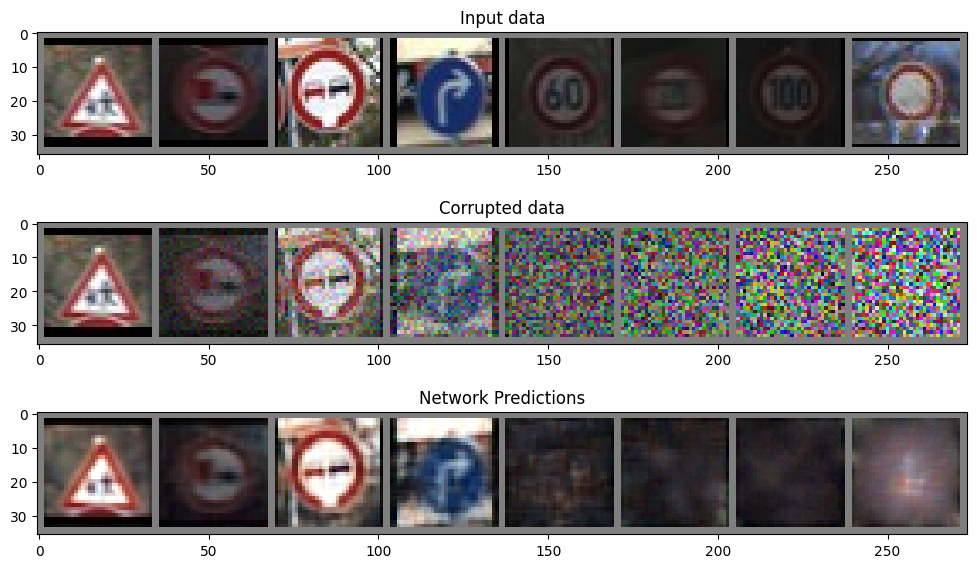

In [49]:
# import cv2

model.eval()

# @markdown Visualizing model predictions on noisy inputs:

# Fetch some data
x, y = next(iter(dm.train_dataloader()))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = model.corrupt(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = model(noised_x).detach().cpu()

print(torchvision.utils.make_grid(x).size())

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow((torchvision.utils.make_grid(x).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))
axs[1].set_title("Corrupted data")
axs[1].imshow((torchvision.utils.make_grid(noised_x).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))
axs[2].set_title("Network Predictions")
axs[2].imshow((torchvision.utils.make_grid(preds).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))

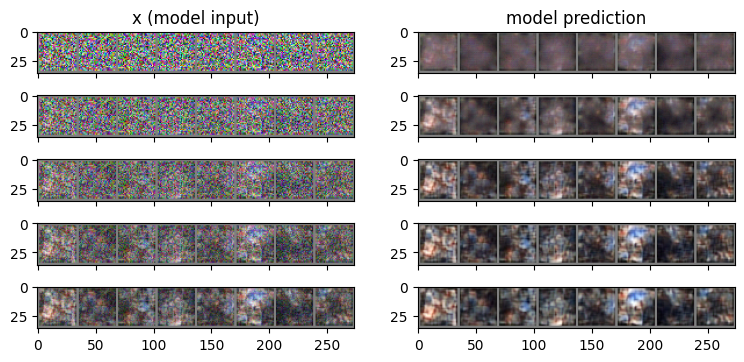

In [50]:
# @markdown Sampling strategy: Break the process into 5 steps and move 1/5'th of the way there each time:
n_steps = 5
x = 2 * torch.rand(8, 3, 32, 32) - 1  # Start from random FIXED TO [-1, 1]
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = model(x)  # Predict the denoised x0
        pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
        mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
        x = x * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
        step_history.append(x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow((torchvision.utils.make_grid(step_history[i]).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))
    axs[i, 1].imshow((torchvision.utils.make_grid(pred_output_history[i]).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))

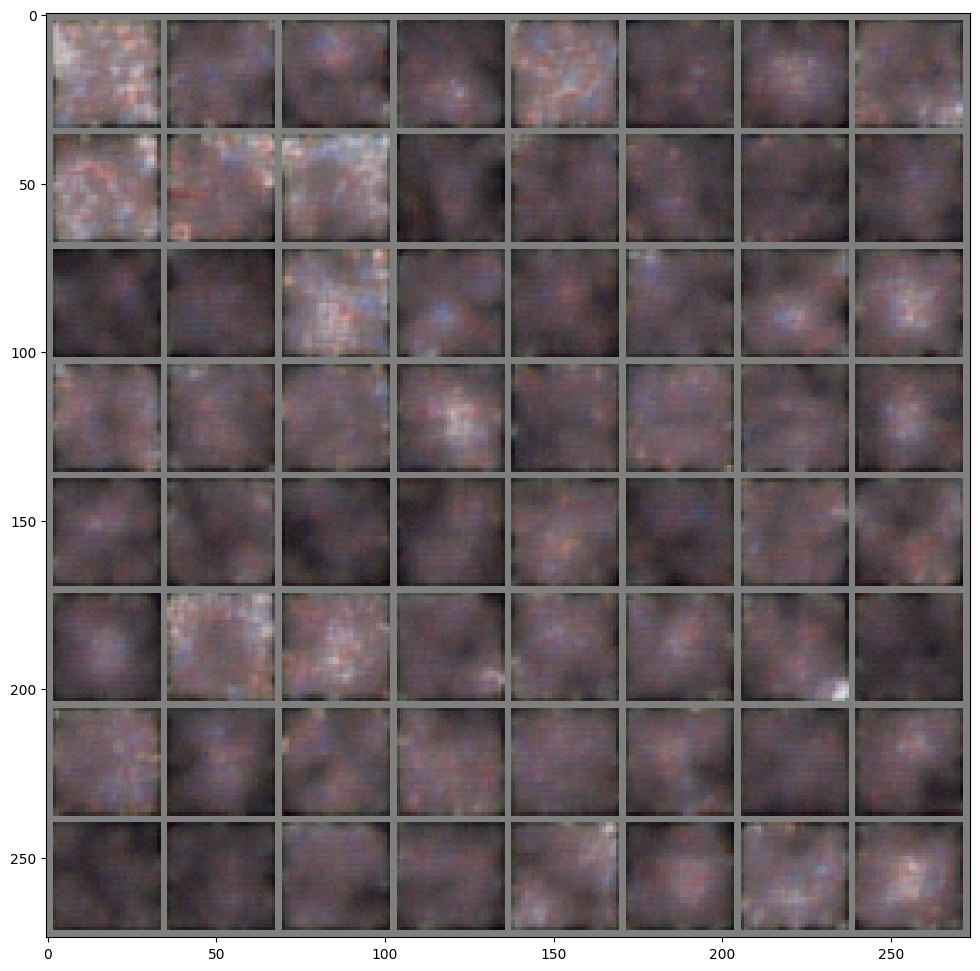

In [52]:
# @markdown Showing more results, using 40 sampling steps
n_steps = 1  # FIXME getting brighter with every iteration, possibly noise vs image distributiuon issue? ([0, 1] vs [-1, 1])
x = 2 * torch.rand(64, 3, 32, 32) - 1 # and one more fix there
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (1 - (i / n_steps))  # Starting high going low
    with torch.no_grad():
        pred = model(x)
        mix_factor = 1 / (n_steps - i)
        x = x * (1 - mix_factor) + pred * mix_factor
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow((torchvision.utils.make_grid(x).permute(1, 2, 0).add(1).mul(127.5).clamp(0, 255).to(torch.int32)))